## Imports and Functions

In [10]:
import numpy as np
from tqdm import tqdm
import math
from time import time
from multiprocessing import Pool
#from imblearn.over_sampling import KMeansSMOTE, SMOTE
from sklearn import preprocessing
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import plotly.express as px
import umap
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import random

In [ ]:
def magnitude(sample):
    mag_vector = []
    for s in sample:
        mag_vector.append(math.sqrt(sum([s[0]**2, s[1]**2, s[2]**2])))
    return mag_vector

def A(sample):
    feat = []
    for col in range(0,sample.shape[1]):
        average = np.average(sample[:, col])
        feat.append(average)

    return np.mean(feat)


def SD(sample):
    feat = []
    for col in range(0, sample.shape[1]):
        std = np.std(sample[:, col])
        feat.append(std)

    return np.mean(feat)


def AAD(sample):
    feat = []
    for col in range(0, sample.shape[1]):
        data = sample[col,:]
        add = np.mean(np.absolute(data - np.mean(data)))
        feat.append(add)

    return np.mean(feat)


def ARA(sample):
    #Average Resultant Acceleration[1]:
    # Average of the square roots of the sum of the values of each axis squared √(xi^2 + yi^2+ zi^2) over the ED
    feat = []
    sum_square = 0
    sample = np.power(sample, 2)
    for col in range(0, sample.shape[1]):
        sum_square = sum_square + sample[:, col]

    sample = np.sqrt(sum_square)
    average = np.average(sample)
    feat.append(average)
    return np.mean(feat)

def COR(sample):
    feat = []
    for axis_i in range(0, sample.shape[1]):
        for axis_j in range(axis_i+1, sample.shape[1]):
            cor = np.corrcoef(sample[:, axis_i], sample[:, axis_j])
            cor = 0 if np.isnan(cor) else cor[0][1]
            feat.append(cor)

    return np.mean(feat)


def mag_mean(sample):
    mag = magnitude(sample)
    ft_mean = np.mean(mag)
    return ft_mean

def mag_std(sample):
    mag = magnitude(sample)
    ft_std = np.std(mag)
    return ft_std


def feature_extraction(sample):
    """
    Derive three activity intensity cues: mean and standard deviation of activity intensity,
    and duration of immobility during assessment window to summarize the data.
    # Average - A,
    # Standard Deviation - SD,
    # Average Absolute Difference - AAD,
    # Average Resultant Acceleration - ARA(1),
    """
    features = []

    mag = magnitude(sample)
    features = np.mean(mag)
    features = np.hstack((features, np.std(mag)))
    features = np.hstack((features, A(sample)))
    features = np.hstack((features, SD(sample)))
    features = np.hstack((features, AAD(sample)))
    features = np.hstack((features, ARA(sample)))

    return features


In [ ]:
def get_clinical_data(y):
    regression_val = [0, 2, 4, 5, 6, 8, 10, 12, 14, 16]

    clin_var = y[:, regression_val]

    print("\nClinical variables (regression) used:\n")
    for idx in regression_val:
        print(f"{y_col_names[idx]}")

    return clin_var.astype(np.float32)


In [6]:
def clean_target(X, y, X_char, col_target):
    if '-1' in np.unique(y[:, col_target]):
        idxs = np.argwhere(np.array(y[:, col_target]) != '-1')
        X = X[idxs]
        y = y[idxs]
        X_char = X_char[idxs]
    return np.squeeze(X), np.squeeze(y), np.squeeze(X_char)

def clean_clin_data(X, y, X_char):
    idxs = []
    for i in range(len(y)):
        if '-1' not in y[i, :]:
            idxs.append(i)
    X = X[idxs]
    y = y[idxs]
    X_char = X_char[idxs]      
    return np.squeeze(X), np.squeeze(y), np.squeeze(X_char)

In [ ]:
def get_cmap(n, name='gist_rainbow'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def plot_features(X, y, y_real, title, columns):
    n_class = len(np.unique(y))
    if X.shape[-1] > 3:
        reducer = PCA(n_components=3)
        #reducer = umap.UMAP(n_components=3)
        principalComponents = reducer.fit_transform(X)
        print("Dimisionality reduced by UMAP")
    else:
        principalComponents = X
    principalDf = pd.DataFrame(data=principalComponents,
                               columns=['First Component', 'Second Component', 'Third Component'])

    y_dt = pd.DataFrame(data=y, columns=['dataset'])

    finalDf = pd.concat([principalDf, y_dt, y_real], axis=1)

    hover_dict = {'First Component': False, 'Second Component':False, 'Third Component':False, 'dataset':True}
    for col in y_real.columns:
        hover_dict[col] = True

    ######### 3D ##############
#     fig = px.scatter_3d(finalDf, x='First Component', y='Second Component', z='Third Component',
#               color='class', opacity=0.7, hover_data=hover_dict)
    
#     # tight layout
#     fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
#     fig.show()

    fig2 = px.scatter(finalDf, x='First Component', y='Second Component', title=title + " (" + 'dataset' + ')',
                  color='dataset', opacity=0.7, hover_data=hover_dict, color_discrete_sequence=px.colors.qualitative.Dark24)

    # tight layout
    #fig2.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig2.show()
    
    ######### 2D ##############
    for col in y_real.columns[columns]:
        fig2 = px.scatter(finalDf, x='First Component', y='Second Component', title=title + " (" + col + ')',
                  color=col, opacity=0.7, hover_data=hover_dict, color_discrete_sequence=px.colors.qualitative.Dark24)

        # tight layout
        #fig2.update_layout(margin=dict(l=0, r=0, b=0, t=0))
        fig2.show()
        

In [42]:
def plot_accel(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    data = X[indices]
    labels = y[indices]
    zero = np.where(labels == 'mild')[0][0]
    one = np.where(labels == 'severe')[0][0]
    sample1 = data[zero]
    sample2 = data[one]
    
    plt.subplot(2, 1, 1)
    plt.plot(sample1[:, 0])
    plt.plot(sample1[:, 1])
    plt.plot(sample1[:, 2])
    plt.title(labels[zero])

    plt.subplot(2, 1, 2)
    plt.plot(sample2[:, 0])
    plt.plot(sample2[:, 1])
    plt.plot(sample2[:, 2])
    plt.title(labels[one])
    
    plt.tight_layout()
    plt.show()

## Read and clean data

In [4]:
data_input_file = "/home/jsenadesouza/DA-healthy2patient/results/outcomes/dataset/t900_INTELLIGENT_PAIN_ADAPT_15min.npz"
tmp = np.load(data_input_file, allow_pickle=True)
X = tmp["X"]
y = tmp['y']
y_col_names = list(tmp['y_col_names'])

In [8]:
def clean(X, y, col_target):
    if '-1' in np.unique(y[:, col_target]):
        idxs = np.argwhere(np.array(y[:, col_target]) != '-1')
        X = X[idxs]
        y = y[idxs]
    return np.squeeze(X), np.squeeze(y)

col_idx_target = y_col_names.index("pain_score_class")
X, y = clean(X, y, col_idx_target)
y_target = y[:, col_idx_target]

In [20]:
np.where(y_target == 'mild')[0][0]

0

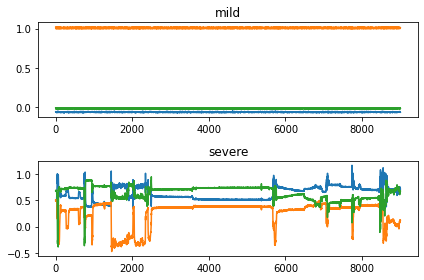

In [60]:
plot_accel(X, y_target)

In [45]:
from scipy import stats

spearman_xy = []
spearman_yz = []
spearman_zx = []
for sample in np.squeeze(X):
    spearman_xy.append(stats.spearmanr(sample[:, 0], sample[:, 1]).correlation)
    spearman_yz.append(stats.spearmanr(sample[:, 1], sample[:, 2]).correlation)
    spearman_zx.append(stats.spearmanr(sample[:, 2], sample[:, 0]).correlation)


/home/jsenadesouza/.conda/envs/jessica/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


KeyboardInterrupt: 

In [ ]:

print(f'spearman_xy = {np.nanmean(spearman_xy)}')
print(f'spearman_yz = {np.nanmean(spearman_yz)}')
print(f'spearman_zx = {np.nanmean(spearman_zx)}')

In [ ]:
new_X_data = []
new_y_target = []
for xx, yy in zip(X, y):
    if yy[7] == "severe":
        new_X_data.append(xx)
        new_y_target.append(yy)

X = np.array(new_X_data)
y = np.array(new_y_target)

## Extract features

In [ ]:
X_trasp = np.transpose(np.squeeze(X), (0, 1, 2))
print("Extracting Features")
start = time()
with Pool(30) as p:
        X_feat = p.map(magnitude, X_trasp)
end = time()
print(f"{end-start:.4} seconds passed.")


In [ ]:
print("clinical data columns")
for i, j in enumerate(y_col_names):
    print(f'{i} : {j}')

X_feat = np.array(X_feat)

class_val = [1, 3,5, 7, 9, 11, 13, 15, 16, 17]

y_df = pd.DataFrame(y[:, class_val], columns=np.array(y_col_names)[class_val])

print("\nClinical variables (categorized) used:\n")
for idx in class_val:
    print(f"{y_col_names[idx]}")

In [ ]:
X_data = X_feat
print(X_data.shape)
columns_size = X_data.shape[1]
y_target = ['PAIN' if 'P' in x else 'ADAPT' if "I" in x else 'Intel_ICU' for x in y[:, -1]]
print(np.array(y_target).shape)

In [ ]:
from combat.pycombat import pycombat
df_data = pd.DataFrame(X_feat.T)
print(df_data.shape)
print(np.array(y_target).shape)
#X_data_batch = pycombat(df_data, y_target)

#print(X_data.shape)
#print(X_data_batch.T.shape)
#plot_features(X_data_batch.T, y_target, y_df, "accel data", [0,1])
plot_features(X_data, y_target, y_df, "accel data", [3,4])

In [ ]:
def plot_acceleration(sample):

    fig, ax = plt.subplots(figsize=(10,6))
    time = np.arange(0, len(sample))
  # add every single subplot to the figure with a for loop
    sns.lineplot(sample[:, 0], label='x', ax=ax)
    sns.lineplot(sample[:, 1], label='y', ax=ax)
    sns.lineplot(sample[:, 2], label='z', ax=ax)
    #ax.title.set_text(label + '\n' + str(v))
    #ax.set_ylim(-0.5,0.5)
    #ax.legend()
    #plt.axis('equal')
    plt.show()

In [ ]:
plot_acceleration(np.squeeze(X[600]))

In [ ]:
print(X_data_batch.T.shape)
plot_features(X_data_batch.T, y_target, y_class, y_df, 'cam', "clinical data")

In [ ]:
X_data = np.concatenate([demo], axis=1)
print(X_data.shape)
plot_features(X_data, y_target,  y_class,"Demographics")

In [ ]:
X_data = np.concatenate([poi, np.ones(poi.shape)], axis=1)
print(X_data.shape)
plot_features(X_data, y_target, "Percentage of Immobile time")

In [ ]:
X_data = np.concatenate([X_feat], axis=1)
print(X_data.shape)
plot_features(X_data, y_target, "Accelerometer handcrafted features")

In [ ]:
X_data = np.concatenate([X_feat, clin_data, X_char], axis=1)
print(X_data.shape)
plot_features(X_data, y_target, "All features")

In [ ]:
np.unique(y_target, return_counts=True)